In [76]:
!pip3 install wordcloud

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.5/160.5 kB 9.0 MB/s eta 0:00:00

[notice] A new release of pip available: 22.2.2 -> 23.0
[notice] To update, run: python3.10 -m pip install --upgrade pip


In [2]:
import nltk
from nltk.corpus import PlaintextCorpusReader
import re
from nltk.corpus import stopwords
from nltk.stem.porter import *
from nltk.probability import FreqDist

import gensim
from gensim import corpora
from gensim import similarities
from gensim import models

from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
import seaborn as sns

## EDA

### EDA at words level

In [3]:
file_directory = 'text_converter'

filename_pattern = '.+\.txt'

my_corpus = PlaintextCorpusReader(file_directory, filename_pattern)
#print(my_corpus.fileids())

#Number of documents in the collection.
print(len(my_corpus.fileids()))

# tokenisation + total num of words
justice = my_corpus.words()
print(len(justice))
print(type(justice))

# Get the top-20 most frequent words in the file. User FreqDist an most_common
fdist_sg = nltk.FreqDist(justice)

# The top-20 most frequent words in the file
print(fdist_sg.most_common(20))

# Number of *unique* words in the file
filtered_word_freq = dict((word, freq) for word, freq in fdist_sg.items() if not word.isdigit())
print(len(filtered_word_freq))

1
120159
<class 'nltk.corpus.reader.util.StreamBackedCorpusView'>
[('.', 5988), (',', 5780), ('the', 5100), ('of', 3296), ('to', 2949), ('and', 2214), ('a', 2050), ('that', 1494), ('in', 1345), ('is', 1303), ('’', 1183), ('for', 942), ('it', 799), ('not', 728), ('s', 713), ('as', 687), (':', 665), ('“', 655), ('be', 644), ('we', 642)]
9660


In [4]:
# Data Preprocessing starts here
stemmer = PorterStemmer()
stop_list = stopwords.words('english')


#Lowercase
justice_lower = [w.lower() for w in justice]
# remove punctuations
justice_re = [w for w in justice_lower if re.search('^[a-z0-9]+$',w)]
# remove stop words
justice_words = [w for w in justice_re if w not in stop_list]
# stemming 
justice_stemmed = [stemmer.stem(w) for w in justice_words]
    
print(len(justice_stemmed))
print(justice_stemmed[:20])

56489
['justic', 'michael', 'sandel', 'book', 'produc', 'epub', 'format', 'internet', 'archiv', 'book', 'page', 'scan', 'convert', 'epub', 'format', 'automat', 'process', 'reli', 'optic', 'charact']


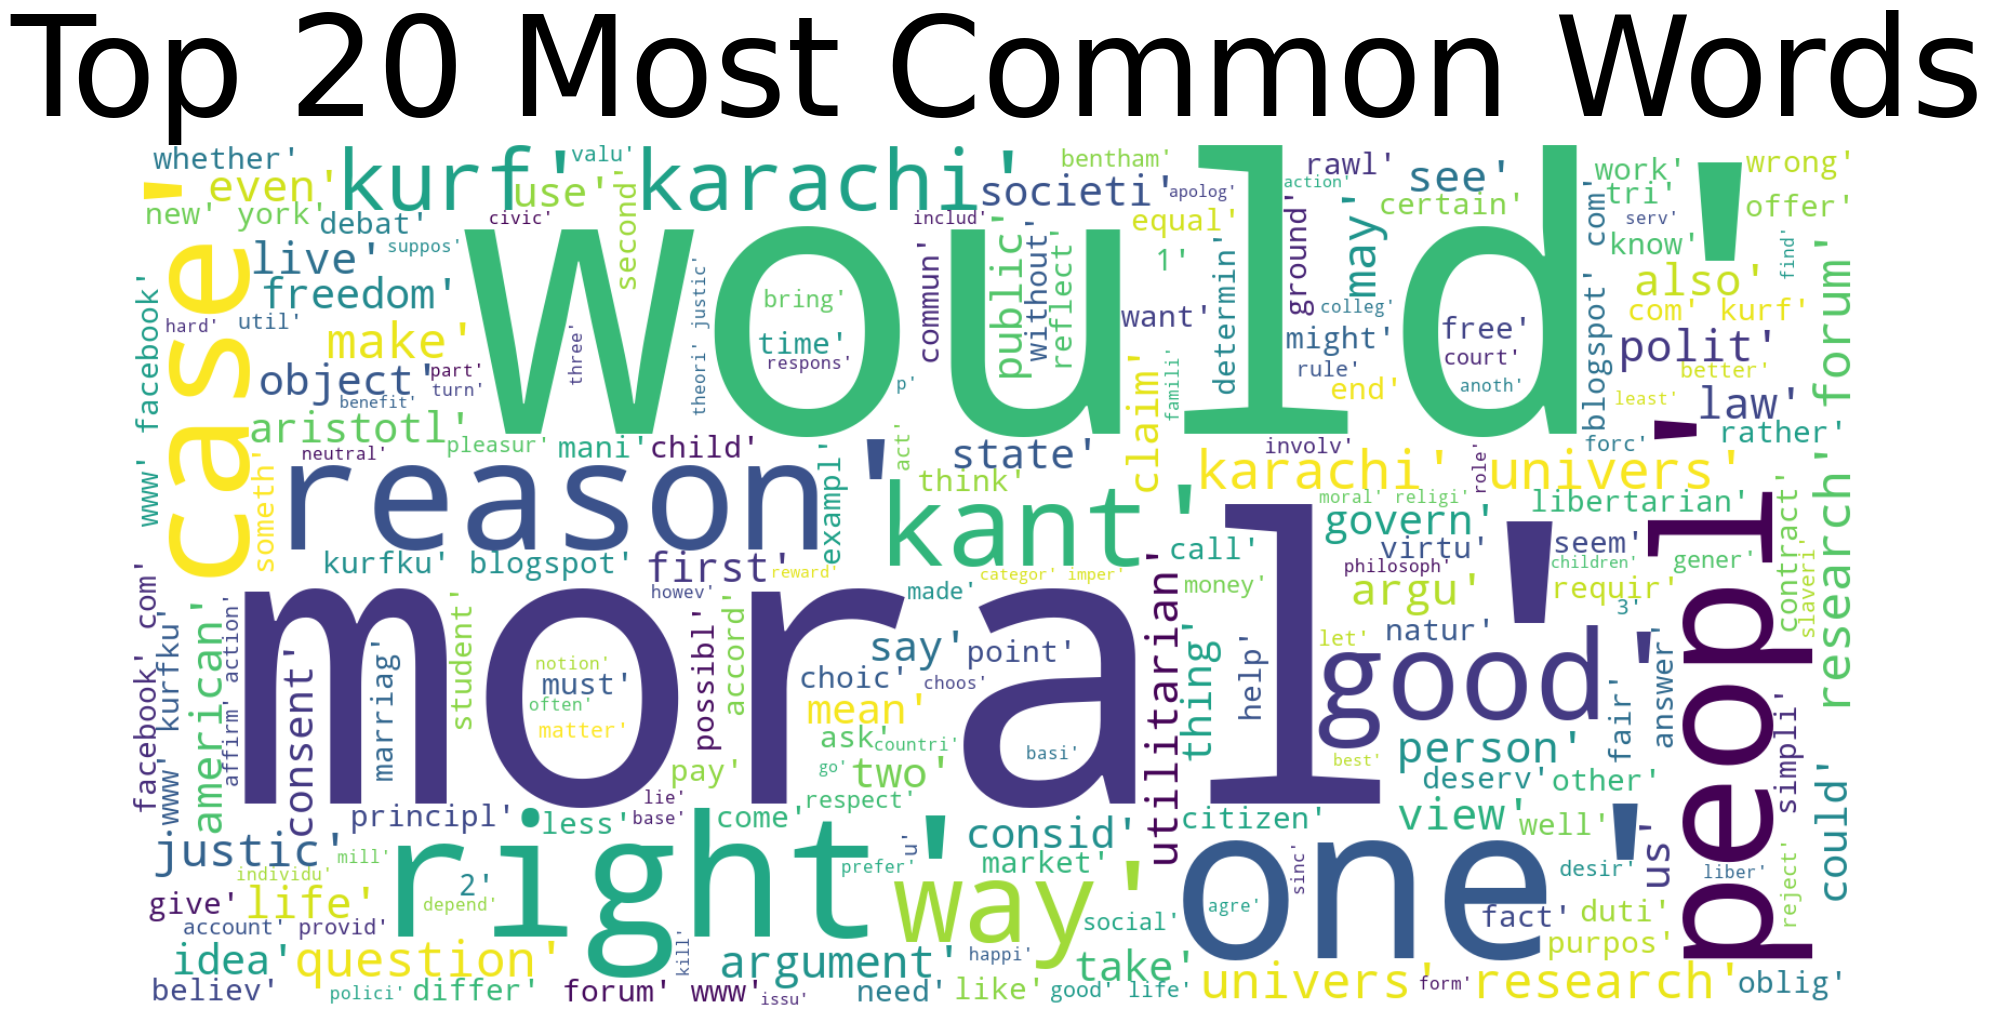

9660


In [5]:
# Get the top-20 most frequent words in the file. User FreqDist an most_common
wordcloud = WordCloud(width=1600, height=800, background_color='white').generate(str(justice_stemmed))
fig = plt.figure(figsize=(30,10), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 20 Most Common Words', fontsize=100)
plt.tight_layout(pad=0)
plt.show()

# Number of *unique* words in the file
filtered_word_freq = dict((word, freq) for word, freq in fdist_sg.items() if not word.isdigit())
print(len(filtered_word_freq))

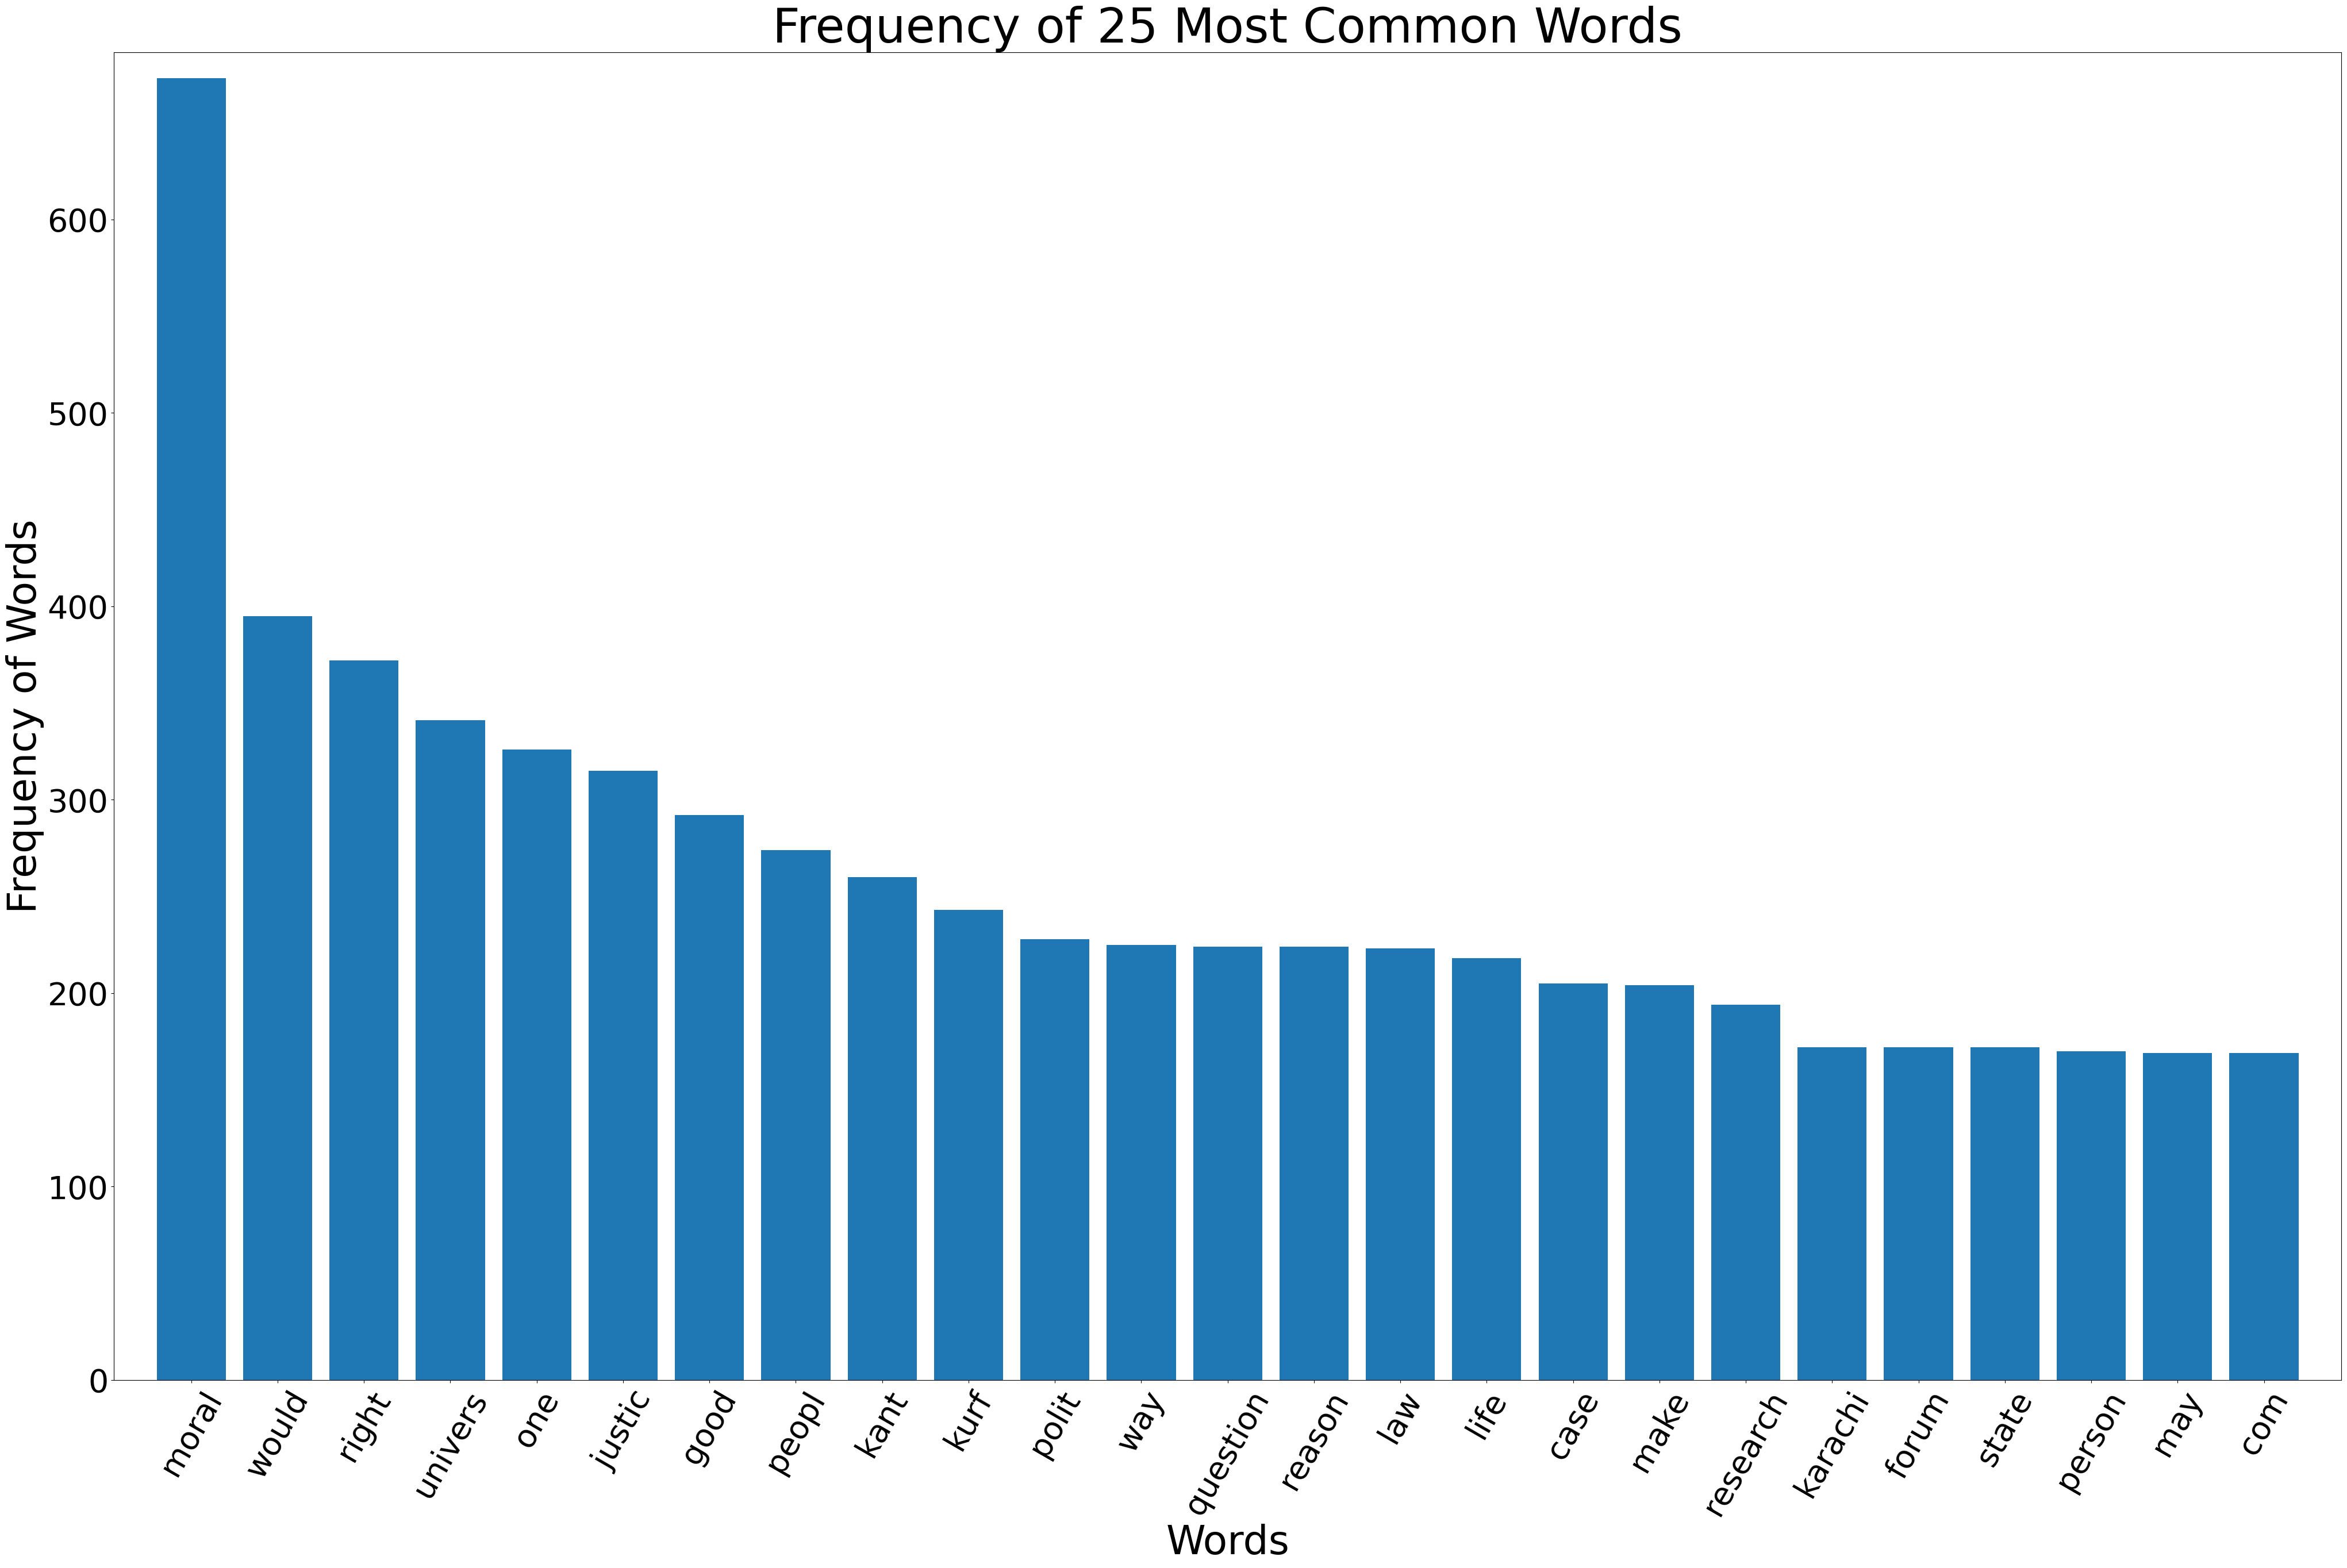

In [6]:
fdist_sg = FreqDist(justice_stemmed).most_common(25)
# print(fdist_sg.most_common(20))

x, y = zip(*fdist_sg)
plt.figure(figsize=(50,30))
plt.margins(0.02)
plt.bar(x, y)
plt.xlabel('Words', fontsize=50)
plt.ylabel('Frequency of Words', fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.title('Frequency of 25 Most Common Words', fontsize=60)
plt.show()

### EDA at sentence level

In [7]:
# sentence splitting in a nested list
justice_split = my_corpus.sents('test.txt')
# print(justice_split[:10])  

justice_lower_words = list()
for s in justice_split:
    #Lowercase
    sen = [w.lower() for w in s]
    # remove punctuations
    sentence = [w for w in sen if re.search('^[a-z0-9]+$',w)]
    # remove empty lists
    if len(sentence) > 0:
        justice_lower_words.append(sentence)
print(len(justice_lower_words))
print(justice_lower_words[:5])

5507
[['justice', 'michael', 'sandel', 'this', 'book', 'was', 'produced', 'in', 'epub', 'format', 'by', 'the', 'internet', 'archive'], ['the', 'book', 'pages', 'were', 'scanned', 'and', 'converted', 'to', 'epub', 'format', 'automatically'], ['this', 'process', 'relies', 'on', 'optical', 'character', 'recognition', 'and', 'is', 'somewhat', 'susceptible', 'to', 'errors'], ['the', 'book', 'may', 'not', 'offer', 'the', 'correct', 'reading', 'sequence', 'and', 'there', 'may', 'be', 'weird', 'characters', 'non', 'words', 'and', 'incorrect', 'guesses', 'at', 'structure'], ['some', 'page', 'numbers', 'and', 'headers', 'or', 'footers', 'may', 'remain', 'from', 'the', 'scanned', 'page']]


In [8]:
# stop words removal + stemming 
stemmer = PorterStemmer()

stop_list = stopwords.words('english')
justice_stemmed = list()
for l in justice_lower_words:
    sen = [w for w in l if w not in stop_list]
    stemmed = [stemmer.stem(w) for w in sen]
    justice_stemmed.append(stemmed)
print(len(justice_stemmed))
print(justice_stemmed[:20])

5507
[['justic', 'michael', 'sandel', 'book', 'produc', 'epub', 'format', 'internet', 'archiv'], ['book', 'page', 'scan', 'convert', 'epub', 'format', 'automat'], ['process', 'reli', 'optic', 'charact', 'recognit', 'somewhat', 'suscept', 'error'], ['book', 'may', 'offer', 'correct', 'read', 'sequenc', 'may', 'weird', 'charact', 'non', 'word', 'incorrect', 'guess', 'structur'], ['page', 'number', 'header', 'footer', 'may', 'remain', 'scan', 'page'], ['process', 'identifi', 'imag', 'might', 'found', 'stray', 'mark', 'page', 'actual', 'imag', 'book'], ['hidden', 'page', 'number', 'may', 'avail', 'eread', 'correspond', 'number', 'page', 'print', 'edit', 'exact', 'match', 'page', 'number', 'increment', 'rate', 'correspond', 'print', 'edit', 'may', 'start', 'number', 'print', 'book', 'visibl', 'page', 'number'], ['internet', 'archiv', 'work', 'improv', 'scan', 'process', 'result', 'book', 'meantim', 'hope', 'book', 'use'], ['internet', 'archiv', 'found', '1996', 'build', 'internet', 'librari

In [17]:
# vectorise the words
justice_dict = corpora.Dictionary(justice_stemmed)
token_to_id = justice_dict.token2id
print(type(token_to_id))
# print(token_to_id) ？

# Converting all documents in SGNews Apr2012 to a list of sparse vectors.
justice_vecs = [justice_dict.doc2bow(doc) for doc in justice_stemmed]
print(justice_dict)

# compare similarity (not done)
sample_index = similarities.SparseMatrixSimilarity(justice_vecs, 5783)

<class 'dict'>
Dictionary<5783 unique tokens: ['archiv', 'book', 'epub', 'format', 'internet']...>
